#  Analiza danych przestrzennych z wykorzystaniem pakietów GeoPandas i PySAL

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import libpysal as ps
import pointpats as pp

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def geopandas2pysal(polygon):
    x,y = polygon.exterior.coords.xy
    coords = np.dstack((x,y)).tolist()
    polygon = ps.cg.Polygon(coords)
    return polygon

Powiaty=gpd.read_file("Powiaty.zip")
granice=gpd.GeoDataFrame.dissolve(Powiaty)
s = pd.Series("granice calego kraju") 
granice['Nazwa']=s

Jednorodny proces punktowy Poissona

<AxesSubplot:>

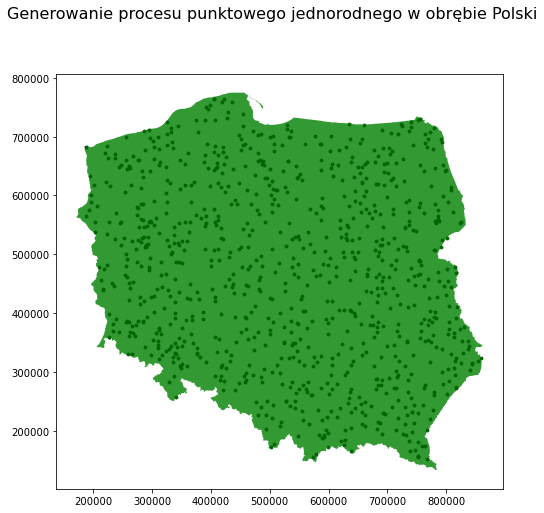

In [3]:
def homogeneous_poisson_on_polygon(intensity, polygon, crs):
    """
    Parameters
    -------
    intensity: float
        Liczba dodatnia określająca intensywność procesu punktowego.
    polygon: libpysal.cg.shapes.Polygon
        Poligon określający obszar, na którym mają zostać wygenerowane punkty.
    crs: str, pyproj.crs.crs.CRS
        Informacja o odwzorowaniu kartograficznym, w który zapisany jest poligon i w którym mają być zapisane wygenerowane punkty.
    Returns
    -------
    points: GeoSeries
        Seria GeoPandas zawierająca wygnerowane punkty zapisane jako obiekty shapely.geometry.point.Point.
    """
    polygon_pp=geopandas2pysal(polygon)
    polygon_w=pp.as_window(polygon_pp)
    points=pp.process.PoissonPointProcess(polygon_w, int(polygon.area*intensity), 1,conditioning=False, asPP=True)
    return gpd.GeoSeries.from_xy(points.realizations[0].points["x"],points.realizations[0].points["y"]).set_crs(crs)

points_h=homogeneous_poisson_on_polygon(3*10**(-9), granice["geometry"][0], granice.crs)

fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle('Generowanie procesu punktowego jednorodnego w obrębie Polski', fontsize=16)
granice.plot(ax=ax, color="green",alpha=0.8)
points_h.plot(ax=ax,color="darkgreen", markersize=8)

Sklasteryzowany proces punktowy Poissona

<AxesSubplot:>

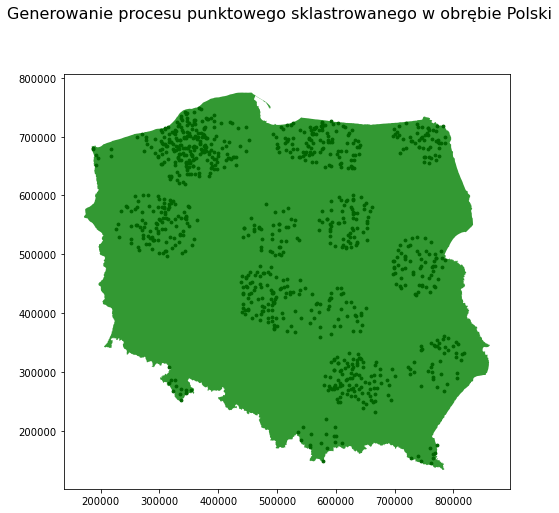

In [4]:
def clustered_poisson_on_polygon(parent_intensity, number_of_points, cluster_radius, polygon, crs):
    """
    Parameters
    -------
    parent_intensity: float
        Liczba dodatnia określająca intensywność macierzystego procesu punktowego.
    number_of_points: int
        Liczba dodatnia określająca ilość generowanych punktów.
    cluster_radius: float
        Liczba dodatnia określająca promień generowanych klastrów.
    polygon: libpysal.cg.shapes.Polygon
        Poligon określający obszar, na którym mają zostać wygenerowane punkty.
    crs: str, pyproj.crs.crs.CRS
        Informacja o odwzorowaniu kartograficznym, w który zapisany jest poligon i w którym mają być zapisane wygenerowane punkty.
    Returns
    -------
    points: GeoSeries
        Seria GeoPandas zawierająca wygnerowane punkty zapisane jako obiekty shapely.geometry.point.Point.
    """
    polygon_pp=geopandas2pysal(polygon)
    polygon_w=pp.as_window(polygon_pp)
    points=pp.process.PoissonClusterPointProcess(polygon_w, number_of_points, int(polygon.area*parent_intensity), cluster_radius, 2,conditioning=False, asPP=True)
    return gpd.GeoSeries.from_xy(points.realizations[0].points["x"],points.realizations[0].points["y"]).set_crs(crs)

points=clustered_poisson_on_polygon(0.5*10**(-10), 1000, 50000, granice["geometry"][0], granice.crs)

fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle('Generowanie procesu punktowego sklastrowanego w obrębie Polski', fontsize=16)
granice.plot(ax=ax, color="green",alpha=0.8)
points.plot(ax=ax,color="darkgreen", markersize=8)

Badanie intensywności procesów punktowych metodą szacowania lokalnego

<AxesSubplot:title={'center':'Proces sklastrowany'}>

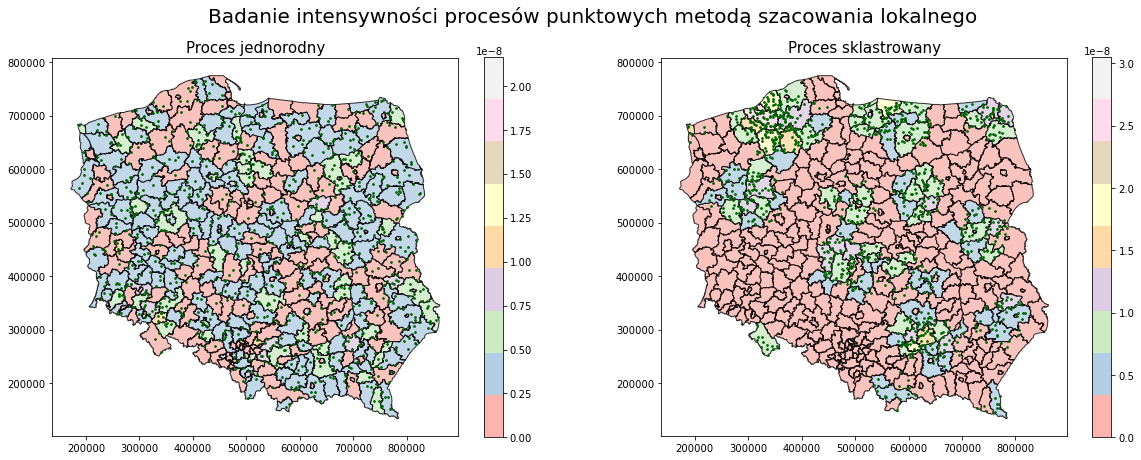

In [5]:
def point_count_on_subregions(points, subregions):
    """
    Parameters
    -------
    points: GeoSeries
        Tablica zawierająca punkty zapisane jako obiekty shapely.geometry.point.Point.
    subregions: GeoDataFrame
        Tablica zawierająca geometrie podobszarów zapisane jako obiekty shapely.geometry.polygon.Polygon.
    Returns
    -------
    counts: Series
        Seria Pandas zawierająca liczbą punktów przypisanych do każdego z podobszarów.
    """
    t=[]
    for s in subregions:
        t.append(np.sum(points.within(s)*1))
    return pd.Series(data=t)

def intensity_on_subregions(points, subregions):
    """
    Parameters
    -------
    points: GeoSeries
        Tablica zawierająca punkty zapisane jako obiekty shapely.geometry.point.Point.
    subregions: GeoDataFrame
        Tablica zawierająca geometrie podobszarów zapisane jako obiekty shapely.geometry.polygon.Polygon.
    Returns
    -------
    counts: Series
        Seria Pandas zawierająca intensywność przypisaną do każdego z podobszarów.
    """
    # YOUR CODE HERE
    points_count=point_count_on_subregions(points, subregions)
    t=[]
    for s in subregions:
        t.append(s.area)
    p=pd.Series(data=t)
    return points_count/t
    
points_h_intensity=intensity_on_subregions(points_h, Powiaty["geometry"])
points_c_intensity=intensity_on_subregions(points, Powiaty["geometry"])

fig, ax = plt.subplots(1,2,figsize=(20,7))
fig.suptitle('Badanie intensywności procesów punktowych metodą szacowania lokalnego', fontsize=20)
ax[0].set_title("Proces jednorodny", fontsize=15)
Powiaty.plot(column=points_h_intensity,ax=ax[0],legend=True, cmap="Pastel1",alpha=0.8,edgecolor="black")
points_h.plot(ax=ax[0],color="darkgreen", markersize=3)

ax[1].set_title("Proces sklastrowany", fontsize=15)
Powiaty.plot(column=points_c_intensity,ax=ax[1],legend=True, cmap="Pastel1",alpha=0.8,edgecolor="black")
points.plot(ax=ax[1],color="darkgreen", markersize=3)